<a href="https://colab.research.google.com/github/noemigarcia27/SImulacion-II/blob/main/Mezclas_de_Dirichlet_de_multinomios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mezclas de Dirichlet-Multinomial (MD)**

El propósito del cuaderno es enseñar **cómo funciona y cómo implementar en PyMC un modelo de mezcla de distribuciones Dirichlet–Multinomial**, que sirve para modelar datos de conteos por categorías (frecuencias de palabras, especies, respuestas, etc.).


**La multinomial de Dirichlet puede entenderse como la extracción de datos de una distribución multinomial**, donde cada muestra tiene un vector de probabilidad ligeramente diferente, el cual, a su vez, se extrae de una distribución de Dirichlet común. Esto contrasta con la distribución multinomial, que asume que todas las observaciones provienen de un único vector de probabilidad fijo.


Modelo| Supuesto | ¿Qué implica?
--- | --- | ---
Multinomial | Todas las observaciones comparten el mismo vector de probabilidades θ | Menos flexible, subestima la variacion entre muestras
Dirichlet-Multinomial | Cada observación tiene su propio vector $\theta_i$, que se genera desde una Dirichlet común | Captura la variabilidad natural entra observaciones


Esto permite que la multinomial de Dirichlet admita datos de conteo más variables (es decir, sobredispersos, que significa que los datos muestran mas variabilidad) que la multinomial.

El DM también es un ejemplo de marginalización de la distribución de una mezcla sobre sus parámetros latentes.

---

Las librerias que vamos a ocupar
import arviz as az

* import arviz as az : Librería para análisis y visualización de modelos bayesianos.
* import matplotlib.pyplot as plt : Librería para hacer gráficos.
* import numpy as np : Librería numérica de Python.
* import pymc as pm : Librería de modelado bayesiano.
* import scipy as sp : Librería matemática y estadística.


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.26.1


In [ ]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## **Datos de simulación**

Propósito de esta sección

Antes de construir el modelo estadístico, se generan datos artificiales controlados, para:

1. Tener un ejemplo claro donde sí se conoce cómo se generaron los datos.
2. Probar si el modelo puede recuperar los parámetros verdaderos.
3. Mostrar que el enfoque marginalizado funciona mejor en práctica.



---



Vamos directamente con el ejemplo de ecología comunitaria, pretendiendo que hemos observado recuentos $ k=5 $ de diferentes especies de árboles en $ n=10 $ diferentes bosques.

Esto forma una matriz de 10 filas (bosques) × 5 columnas (especies). Parametrizaremos esta distribución con tres cosas:

* frac: Fracción esperada de cada especie (promedio de proporciones en todos los bosques).
* conc: Concentración (qué tanto varían las proporciones entre bosques). Valores altos → menos variación.
* total_count: Total de arboles contados en cada bosque

Se usa la distribución Dirichlet–Multinomial (de uno a dos parámetros, $ \alpha = conc \cdot frac $) para modelar este fenómeno.

1. Cada bosque $i$ (observación) tiene su propio vector de proporciones $ p_i $
$$ p_i = Dirichlet(\alpha) $$
donde $ \alpha $ controla la forma promedio de esas proporciones.
2. dado ese vector de proporciones, los conteos observados se generan con una Multinomial:
$$ x_i | p_i \sim Multinomial(N_i, p_i) $$

Este es el modelo generador de los datos simulados.
Cuando se integra $ p_i $, se obtiene directamente la Dirichlet–Multinomial marginal.


In [ ]:
true_conc = 6.0 #Define la concentracion. Cuando varian las proporciones entre bosques
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01]) #Promedio para cada especie
trees = ["pine", "oak", "ebony", "rosewood", "mahogany"]  # Tree species observed
# fmt: off
forests = [  # Forests observed
    "sunderbans", "amazon", "arashiyama", "trossachs", "valdivian",
    "bosc de poblet", "font groga", "monteverde", "primorye", "daintree",
]

# Dimensiones
k = len(trees)
n = len(forests)
total_count = 50

# Creamos la matroz de probabilidades para cada bosque
true_p = sp.stats.dirichlet(true_conc * true_frac).rvs(size=n, random_state=rng) #Arreglo nxk cuyos vectores suman 1
observed_counts = np.vstack(
    [sp.stats.multinomial(n=total_count, p=p_i).rvs(random_state=rng) for p_i in true_p] #vector de conteos de longitud k
)

observed_counts

array([[21,  9, 11,  6,  3],
       [36,  7,  6,  1,  0],
       [ 8, 31,  1, 10,  0],
       [25,  4, 17,  4,  0],
       [43,  6,  1,  0,  0],
       [28, 10, 12,  0,  0],
       [21, 16, 10,  3,  0],
       [16, 32,  2,  0,  0],
       [45,  4,  1,  0,  0],
       [35,  5,  2,  8,  0]])

## **Modelo multinomial**

El primer modelo que ajustaremos a estos datos es un simple modelo multinomial, donde el único parámetro es la fracción esperada de cada categoría, frac, a lo que le daremos un Dirichlet previo. Mientras que el uniforme anterior ( $ \alpha_j = 1 $ para cada j) funciona bien, si tenemos creencias independientes sobre la fracción de cada árbol, podríamos codificar esto en nuestro prior, por ejemplo aumentando el valor de $ \alpha_j $ donde esperamos una mayor fracción de especies-j.




---

Este código define un modelo jerárquico: mismas fracciones por especie, aplicadas a múltiples bosques, con prior uniforme y datos multinomiales.

Genera un diagrama de grafo del modelo, pero unicamnete es visual para verificar que la estgructura es la esperada.

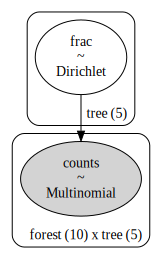

In [ ]:
coords = {"tree": trees, "forest": forests}
with pm.Model(coords=coords) as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    counts = pm.Multinomial(
        "counts", n=total_count, p=frac, observed=observed_counts, dims=("forest", "tree")
    )

pm.model_to_graphviz(model_multinomial)

Este otro codigo ejecuta la inferencia bayesiana del modelo que definimos antes, obtenemos un objeto InfereniceData/trace con cadenas MCMC que se van a usar para diagnosticar.

In [ ]:
with model_multinomial:
    trace_multinomial = pm.sample(chains=4)

Output()

Muestra visualmente cómo convergieron las cadenas MCMC

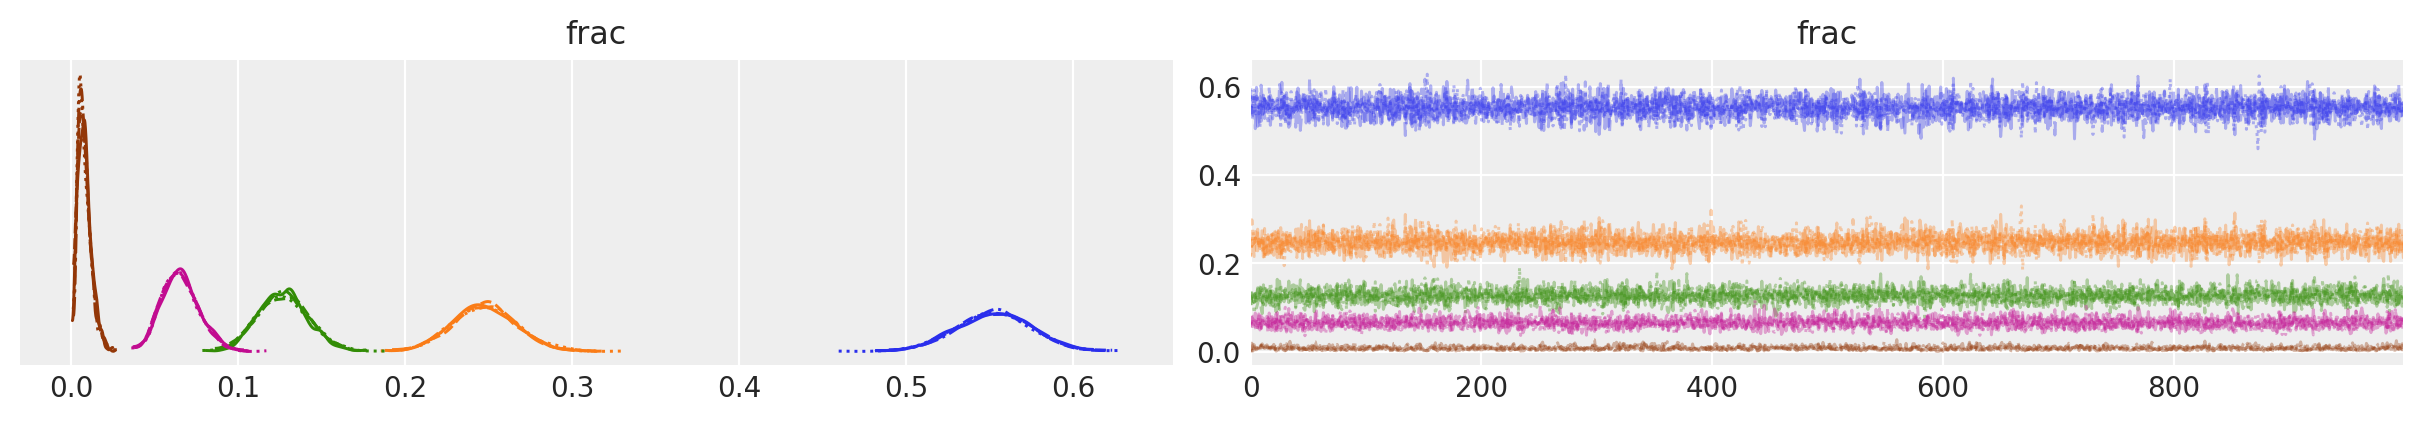

In [ ]:
az.plot_trace(data=trace_multinomial, var_names=["frac"]);

Los gráficos de trazas se ven bastante bien; visualmente, cada parámetro parece moverse alrededor del pozo posterior.



---



In [ ]:
summary_multinomial = az.summary(trace_multinomial, var_names=["frac"])

summary_multinomial = summary_multinomial.assign(
    ess_bulk_per_sec=lambda x: x.ess_bulk / trace_multinomial.posterior.sampling_time,
)

summary_multinomial

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,ess_bulk_per_sec
frac[pine],0.553,0.022,0.511,0.595,0.0,0.0,7318.0,3699.0,1.0,782.978317
frac[oak],0.247,0.019,0.211,0.283,0.0,0.0,6830.0,3575.0,1.0,730.765497
frac[ebony],0.127,0.015,0.098,0.153,0.0,0.0,5096.0,3172.0,1.0,545.238795
frac[rosewood],0.065,0.011,0.045,0.087,0.0,0.0,4109.0,3197.0,1.0,439.636226
frac[mahogany],0.008,0.004,0.002,0.015,0.0,0.0,1398.0,1649.0,1.0,149.576891


Del mismo modo, todos los diagnósticos en la tabla resumen de parámetros se ven bien.

---


EL siguiente codigo nos muestra que cada parámetro tiene su intervalo y encima (o al costado) aparece la línea discontinua indicando el valor real.

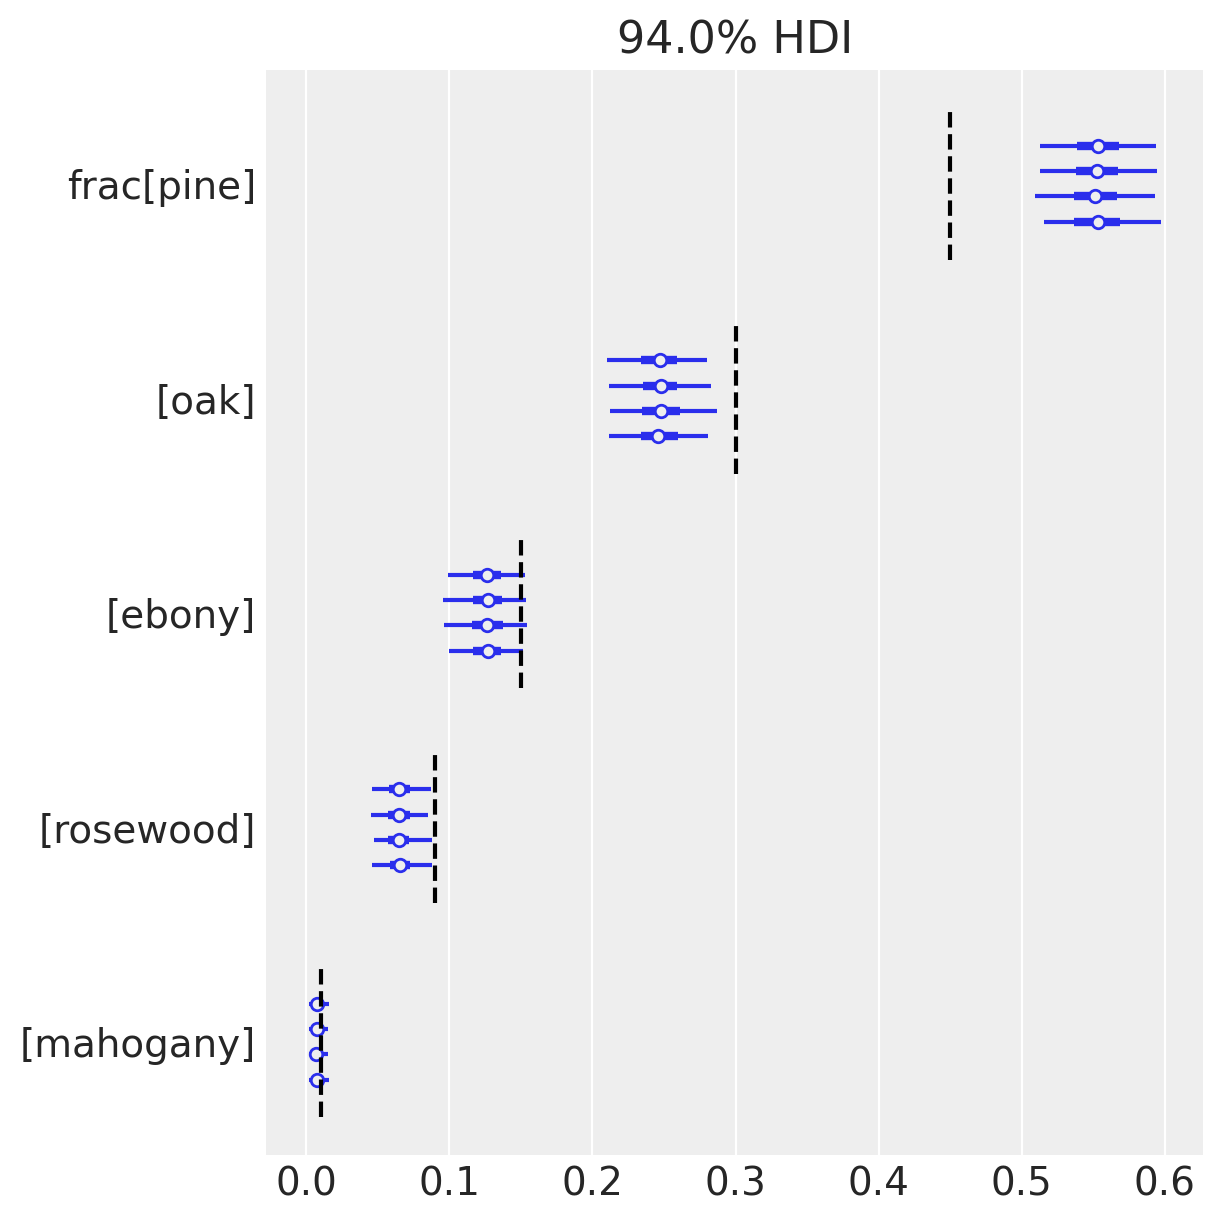

In [ ]:
az.plot_forest(trace_multinomial, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(true_frac))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

A pesar de que las trazas y diagnósticos numéricos lucían bien, la comparación posterior entre intervalos y valores verdaderos revela fallos en la especificación del modelo:

*  Para 3 de 5 especies, el intervalo de credibilidad no contiene el valor verdadero usado en la simulacion

esto indica que el modelo multinomial no captura la estructura real de los datos.

Es una señal clara de mala especificación: el modelo está subestimando la variabilidad o está forzando una composición única que no es consistente con el conjunto de observaciones, porque la realidad (según simulación) incluye variación entre bosques.


---

Solucionemos este modelo utilizando una verificación predictiva posterior, comparando nuestros datos con datos simulados condicionados a nuestras estimaciones posteriores.

Con el siguiente codigo se obtienen muchas replicas de datos que el modelo considera plausibles, dada la incertidumbre posterior.


In [ ]:
with model_multinomial:
    pp_samples = pm.sample_posterior_predictive(trace=trace_multinomial) #Genra datos simulados, usando las muestras del posterior
#pp_samples: Contiene miles de conteos simulados por especie y bosque, como si hubiéramos repetido el experimento

# Añade esas simulaciones al objeto trace para tener todo en un solo lugar
trace_multinomial.extend(pp_samples)

Output()

El siguiente codigo muestra si el modelo entiende realmente cómo se distribuyen los conteos de árboles o solo "adivina" las proporciones.

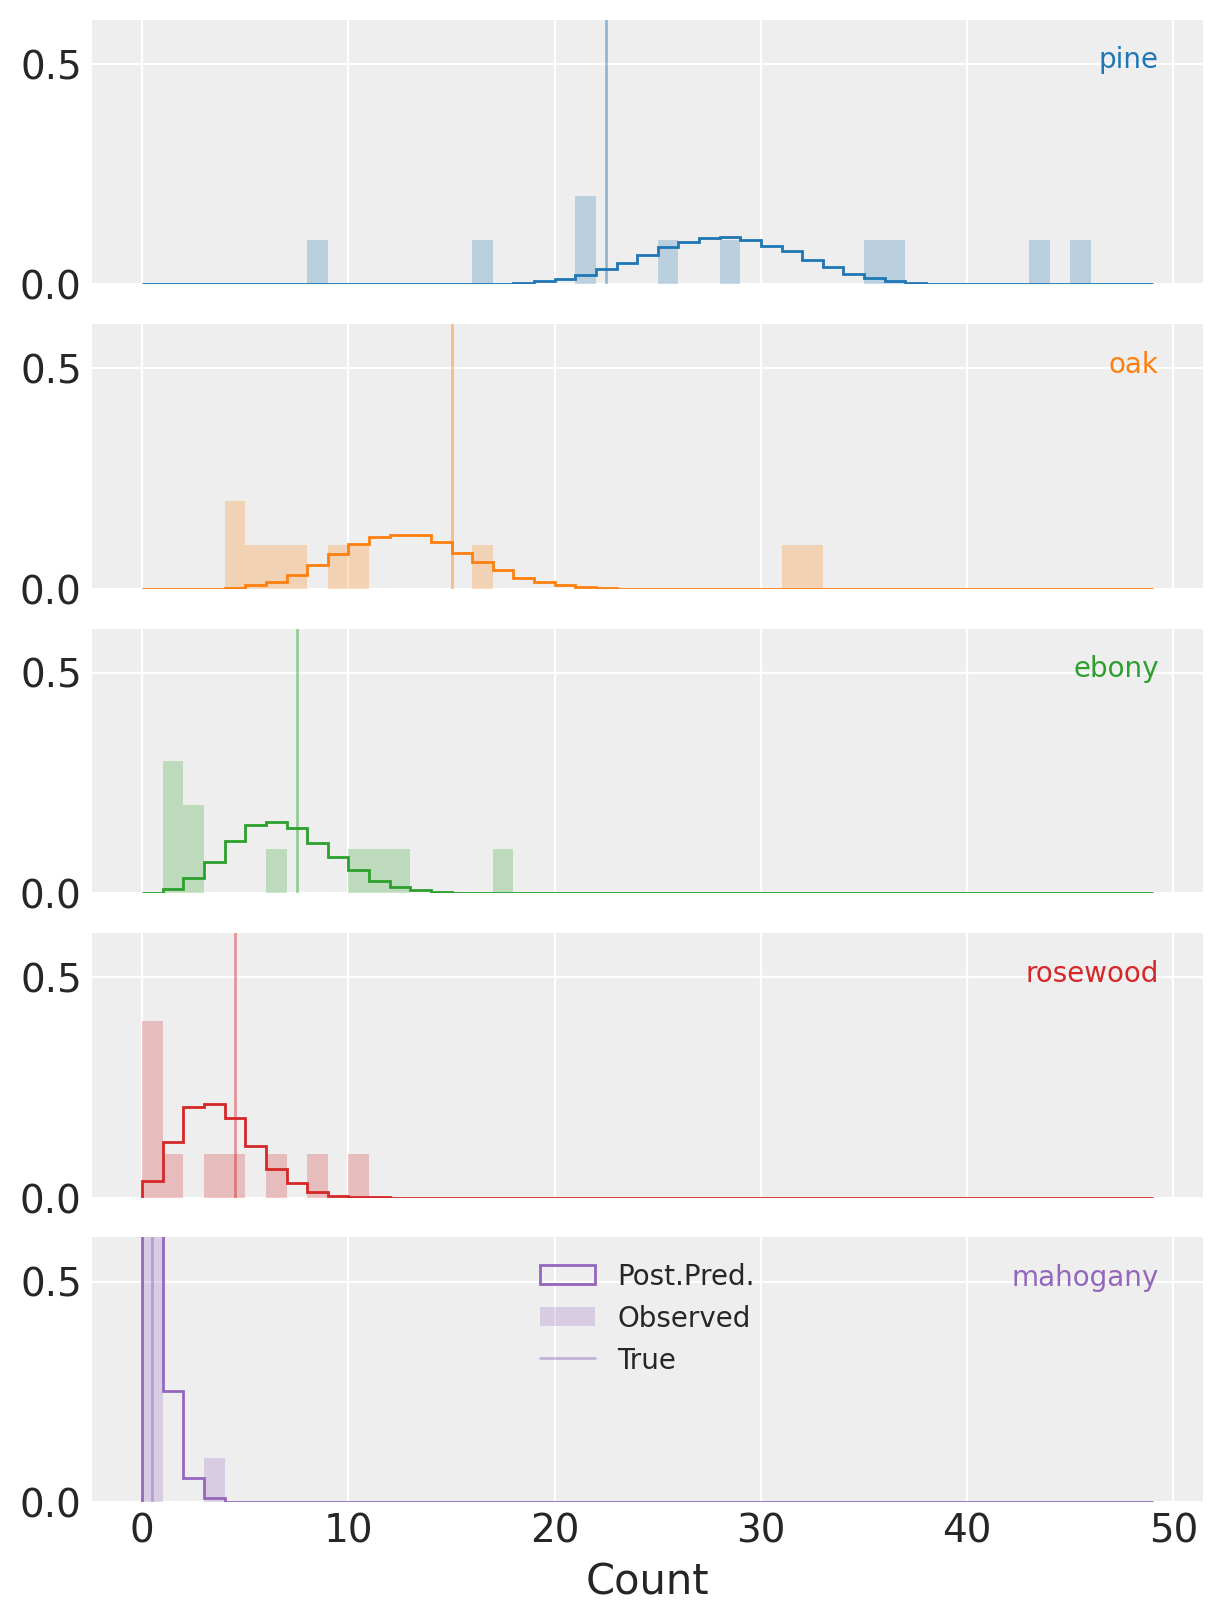

In [ ]:
cmap = plt.get_cmap("tab10")

#crea k subgraficos verticales
fig, axs = plt.subplots(k, 1, sharex=True, sharey=True, figsize=(6, 8))
#Recorre cada especie
for j, ax in enumerate(axs):
    # Asigna un color distinto a cada especie
    c = cmap(j)
    # Histograma de conteos simulados (línea gruesa)
    ax.hist(
        trace_multinomial.posterior_predictive.counts.sel(tree=trees[j]).values.flatten(),
        bins=np.arange(total_count),
        histtype="step",
        color=c,
        density=True,
        label="Post.Pred.",
    )
    # Histograma de conteos reales (área sombreada)
    ax.hist(
        (trace_multinomial.observed_data.counts.sel(tree=trees[j]).values.flatten()),
        bins=np.arange(total_count),
        color=c,
        density=True,
        alpha=0.25,
        label="Observed",
    )
    # Línea vertical en el conteo real esperado
    ax.axvline(
        true_frac[j] * total_count,
        color=c,
        lw=1.0,
        alpha=0.45,
        label="True",
    )
    # Pone el nombre de la especie en la esquina
    ax.annotate(
        f"{trees[j]}",
        xy=(0.96, 0.9),
        xycoords="axes fraction",
        ha="right",
        va="top",
        color=c,
    )

axs[-1].legend(loc="upper center", fontsize=10)
axs[-1].set_xlabel("Count")
axs[-1].set_yticks([0, 0.5, 1.0])
axs[-1].set_ylim(0, 0.6);

Los histogramas muestran que los datos observados están con frecuencia en las colas o fuera de la mayor masa predictiva del modelo. Ej.: para oak (roble) hubo al menos una observación con >30 robles, pero la distribución predicha por el modelo multinomial (que asume homogeneidad) está concentrada en valores mucho menores (cerca del promedio).

Esto indica sobredispersión: la variabilidad entre bosques en los datos reales (simulados) es mayor que la que el modelo multinomial puede producir.

* El multinomial con un p global produce una varianza dada por
$ Var(X_j) = N_{p_j}(1-p_j) $ y covarianzas negativas entre categorías; no incorpora variación adicional entre observaciones.

* En cambio, la verdadera generación (Dirichlet → Multinomial) permite que cada bosque tenga su propio p_i, lo cual amplía la variabilidad marginal de los conteos (Dirichlet–Multinomial tiene mayor varianza marginal).


---

## **Modelo multinomial de Dirichlet: mezcla explícita**

Sigamos adelante y modelemos nuestros datos utilizando la distribución DM.

Para este modelo mantendremos lo mismo antes en las frecuencias esperadas de cada uno especies, frac. También agregaremos un parámetro estrictamente positivo, conc, para la concentración.

En esta iteración de nuestro modelo incluiremos explícitamente el multinomial latente probabilidad, $p_i$, modelando el true_p de nuestras simulaciones (que no haríamos observar en el mundo real).


El siguiente codigo muestra cómo frac y conc generan p, y p genera los counts

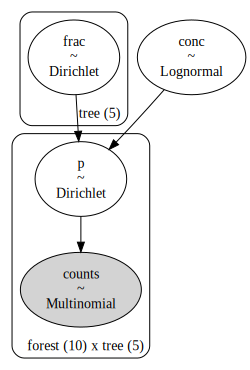

In [ ]:
with pm.Model(coords=coords) as model_dm_explicit:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    p = pm.Dirichlet("p", a=frac * conc, dims=("forest", "tree"))
    counts = pm.Multinomial(
        "counts", n=total_count, p=p, observed=observed_counts, dims=("forest", "tree")
    )

pm.model_to_graphviz(model_dm_explicit)

Compare este diagrama con el primero. Aquí se distribuyó el Dirichlet latente p separa el multinomial de las frecuencias esperadas, frac, teniendo en cuenta la sobredispersión de recuentos en relación con el modelo multinomial simple.

Ahora vamos a ejecutar el muestreo MCM con 4 cadenas

In [ ]:
with model_dm_explicit:
    trace_dm_explicit = pm.sample(chains=4, target_accept=0.9)

Output()

ERROR:pymc.stats.convergence:There were 409 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


El muestreo tomó más tiempo. Esto se debe a que ahora hay muchos más parámetros (~n × k), y la geometría es más compleja.

Este gráfico muestra las trazas (evolución de las muestras en el tiempo) y las densidades posteriores de frac y conc. Sirve para revisar la convergencia visual.

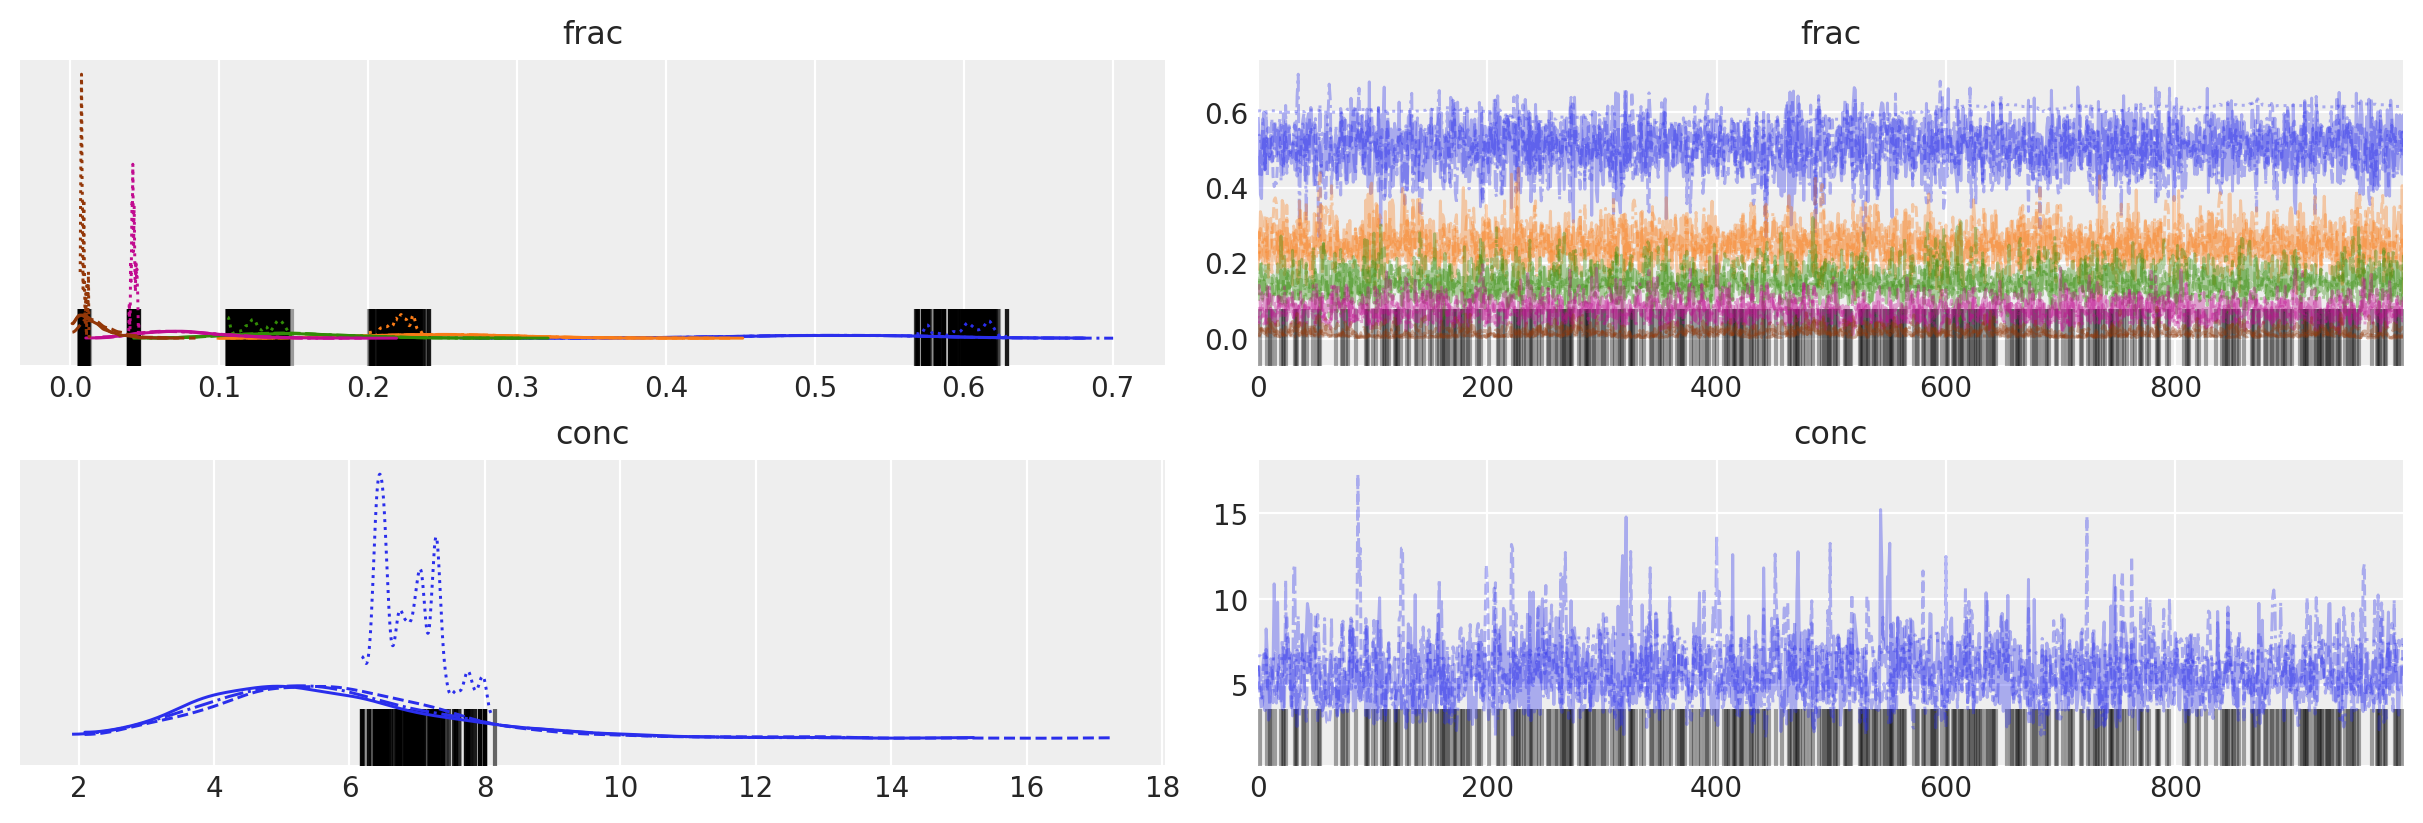

In [ ]:
az.plot_trace(data=trace_dm_explicit, var_names=["frac", "conc"]);

Las divergencias parecen ocurrir cuando la fracción estimada de las especies raras (mahogany) está muy cerca de cero.

El siguiente codio muestr un gráfico forestal para comprobar lo estimado vs lo real

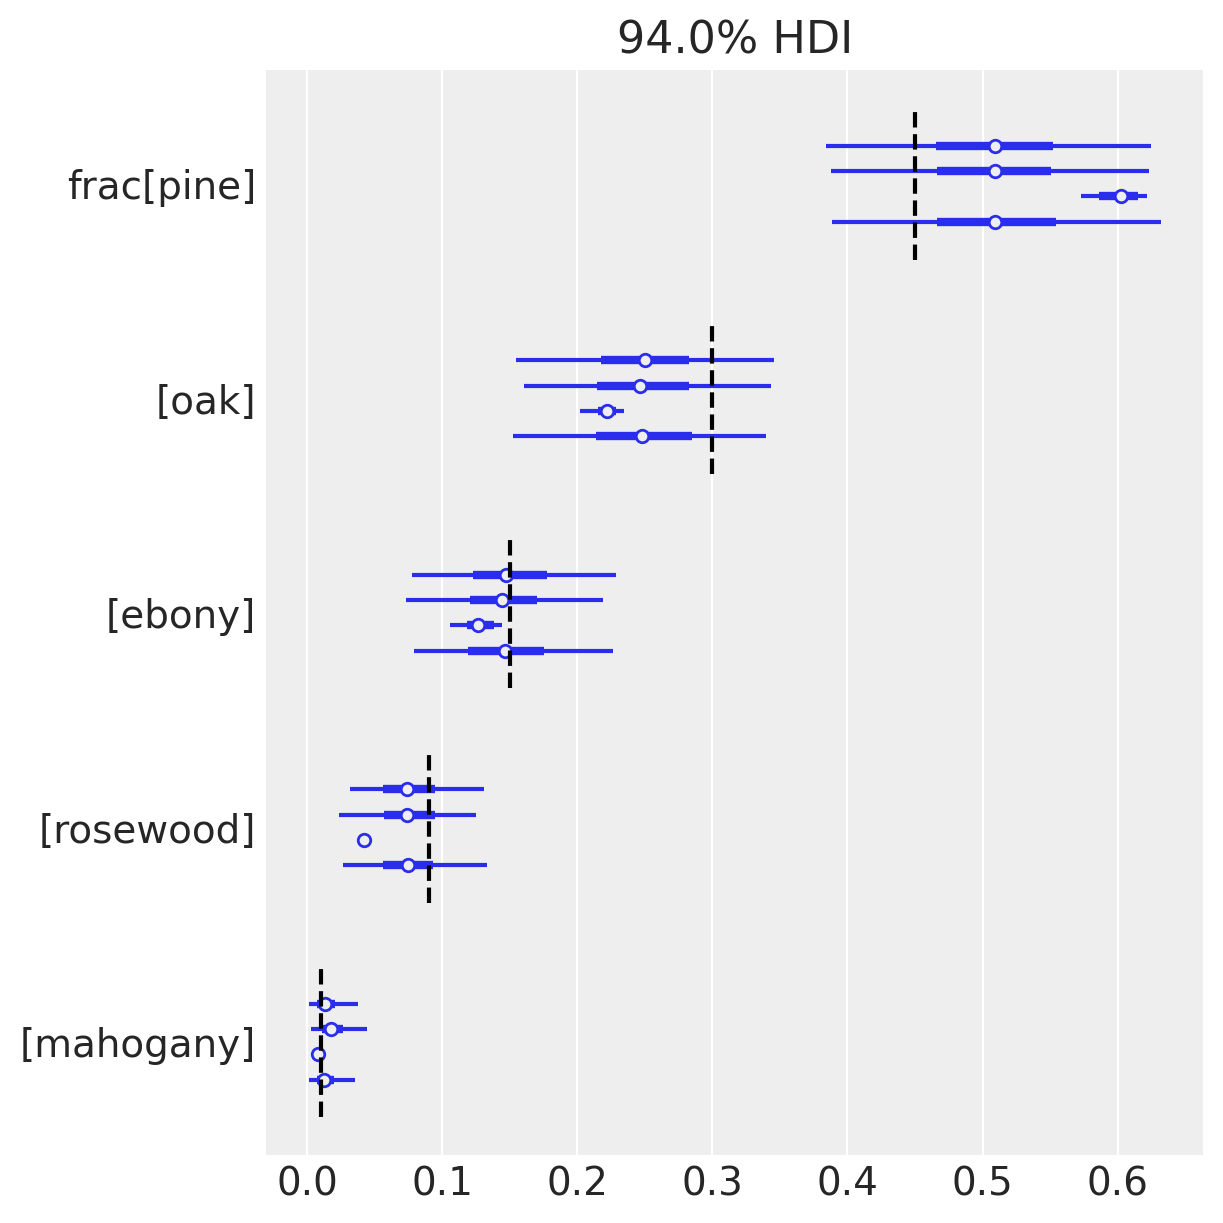

In [ ]:
az.plot_forest(trace_dm_explicit, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(true_frac))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

Los IDH incluyen los valores reales de todas nuestras especies.

El modelado de esta mezcla ha hecho nuestras inferencias robustas a la sobredispersión.

Observe que los IDH son más amplios que antes

In [ ]:
summary_dm_explicit = az.summary(trace_dm_explicit, var_names=["frac", "conc"])
summary_dm_explicit = summary_dm_explicit.assign(
    ess_bulk_per_sec=lambda x: x.ess_bulk / trace_dm_explicit.posterior.sampling_time,
)

summary_dm_explicit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,ess_bulk_per_sec
frac[pine],0.530,0.069,0.402,0.629,0.021,0.001,11.0,284.0,1.29,0.038993
frac[oak],0.243,0.046,0.159,0.334,0.006,0.004,70.0,1988.0,1.18,0.248139
frac[ebony],0.144,0.037,0.083,0.220,0.005,0.003,78.0,2164.0,1.10,0.276498
frac[rosewood],0.068,0.029,0.029,0.124,0.008,0.000,14.0,1585.0,1.21,0.049628
frac[mahogany],0.015,0.011,0.002,0.036,0.002,0.000,34.0,238.0,1.09,0.120525
conc,6.020,1.673,2.575,8.456,0.252,0.069,36.0,2013.0,1.08,0.127615


El modelo DM estima correctamente las fracciones y detecta sobredispersión (conc ≈ 6).

Todos los intervalos de 94% contienen los valores reales — algo que el modelo simple no logró.

Pero el muestreo es ineficiente: ESS bajo y R-hat alto → necesitamos un modelo mejor parametrizado.



---


## **Modelo multinomial de Dirichlet- Marginado**

Afortunadamente, la distribución de Dirichlet es conjugada con el multinomial y por lo tanto existe una forma conveniente y cerrada para los marginados distribución, es decir, la distribución multinomial de Dirichlet.

Aprovechemos esto, marginando el parámetro latente explícito, $p_i$, reemplazando la combinación de este nodo y el multinomial con el DM para hacer un modelo equivalente.


El siguiente codigo dibuja el gráfico probabilístico, donde ahora solo hay un nodo DM en lugar de dos (Dirichlet + Multinomial).

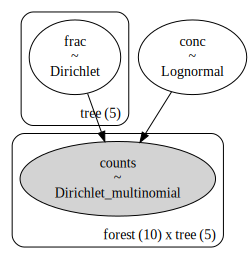

In [ ]:
with pm.Model(coords=coords) as model_dm_marginalized:
    frac = pm.Dirichlet("frac", a=np.ones(k), dims="tree")
    conc = pm.Lognormal("conc", mu=1, sigma=1)
    counts = pm.DirichletMultinomial(
        "counts", n=total_count, a=frac * conc, observed=observed_counts, dims=("forest", "tree")
    )

pm.model_to_graphviz(model_dm_marginalized)

El diagrama de placas muestra que hemos colapsado lo que había sido el Dirichlet latente y el multinomial nodos juntos en un solo nodo DM.

Lo siguiente ejecuta el muestreo MCMC con 4 cadenas

In [ ]:
with model_dm_marginalized:
    trace_dm_marginalized = pm.sample(chains=4)

Output()

Muestra mucho más rápido y sin ninguna de las advertencias anteriores. No hay divergencias, converge sin problemas. Es mucho más veloz porque eliminamos $p_i$ (que tenía 10 × 5 = 50 parámetros adicionales).

Lo siguietne muestra las trazas y densidades posteriores de frac y conc.

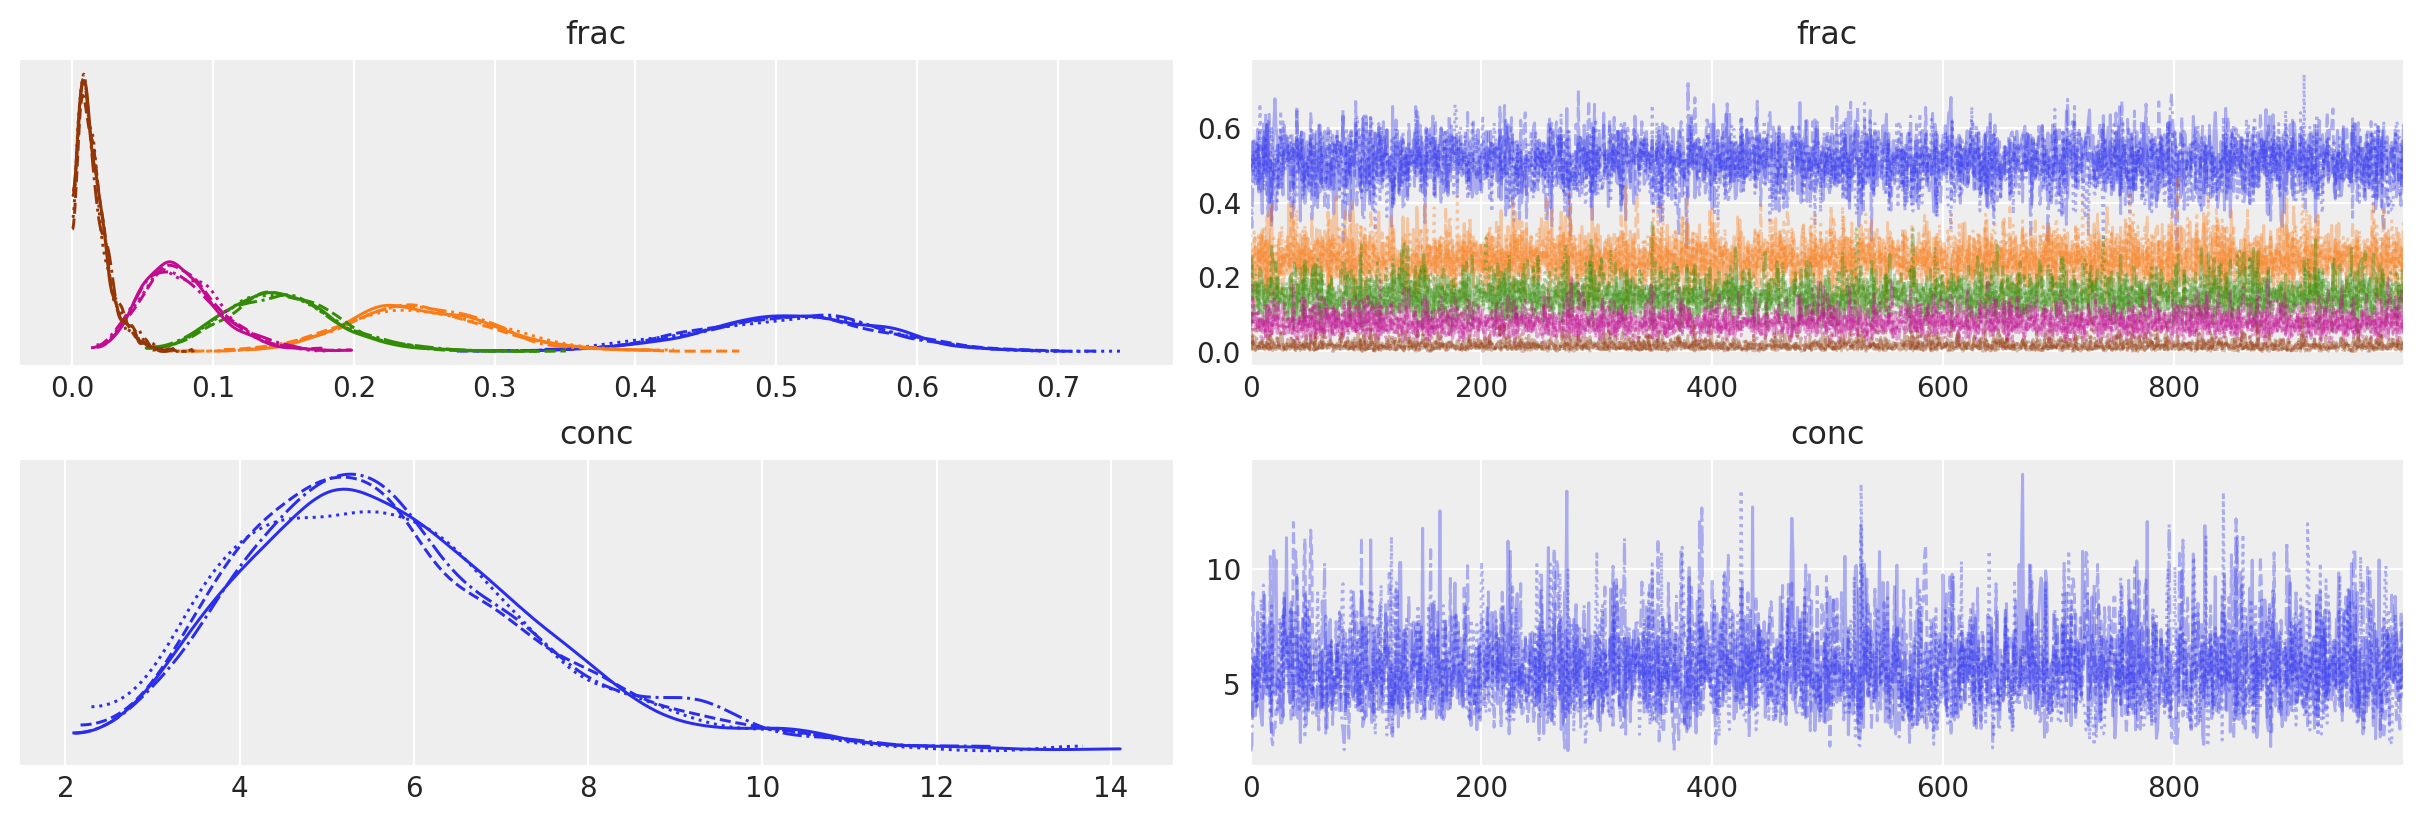

In [ ]:
az.plot_trace(data=trace_dm_marginalized, var_names=["frac", "conc"]);

El muestreo es PERFECTO: cadenas bien mezcladas, distribuciones suaves, convergencia total.
Los gráficos de seguimiento se ven borrosos y los KDE están limpios.

Vamos a calcular los resumenes estadisticos

In [ ]:
summary_dm_marginalized = az.summary(trace_dm_marginalized, var_names=["frac", "conc"])
summary_dm_marginalized = summary_dm_marginalized.assign(
    ess_mean_per_sec=lambda x: x.ess_bulk / trace_dm_marginalized.posterior.sampling_time,
)
assert all(summary_dm_marginalized.r_hat < 1.03)

summary_dm_marginalized

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,ess_mean_per_sec
frac[pine],0.509,0.064,0.385,0.622,0.001,0.001,4079.0,2876.0,1.0,453.480312
frac[oak],0.248,0.051,0.152,0.343,0.001,0.001,5390.0,3071.0,1.0,599.229930
frac[ebony],0.149,0.040,0.077,0.223,0.001,0.001,3819.0,3105.0,1.0,424.574972
frac[rosewood],0.078,0.028,0.030,0.131,0.000,0.000,3659.0,3191.0,1.0,406.787071
frac[mahogany],0.016,0.012,0.000,0.037,0.000,0.000,2804.0,2252.0,1.0,311.732973
conc,5.739,1.764,2.645,9.070,0.030,0.029,3394.0,2562.0,1.0,377.325859


Vemos que R̂ está cerca de 1 en todas partes y ESS sec⁻¹ es mucho más alto.
¡Nuestra reparametrización (marginación) ha mejorado enormemente el muestreo!
(Y, afortunadamente, los IDH se parecen al otro modelo).

Asi, como le hicimos anteriormente vamos a ver los controles predictivos, para ver si los datos que genera el modelo se parecen a los reales

In [ ]:
with model_dm_marginalized:
    pp_samples = pm.sample_posterior_predictive(trace_dm_marginalized)

# Concatenate with InferenceData object
trace_dm_marginalized.extend(pp_samples)

Output()

Vamos a compara visualmente: el DM genera datos indistinguibles de los reales; el multinomial simple no.

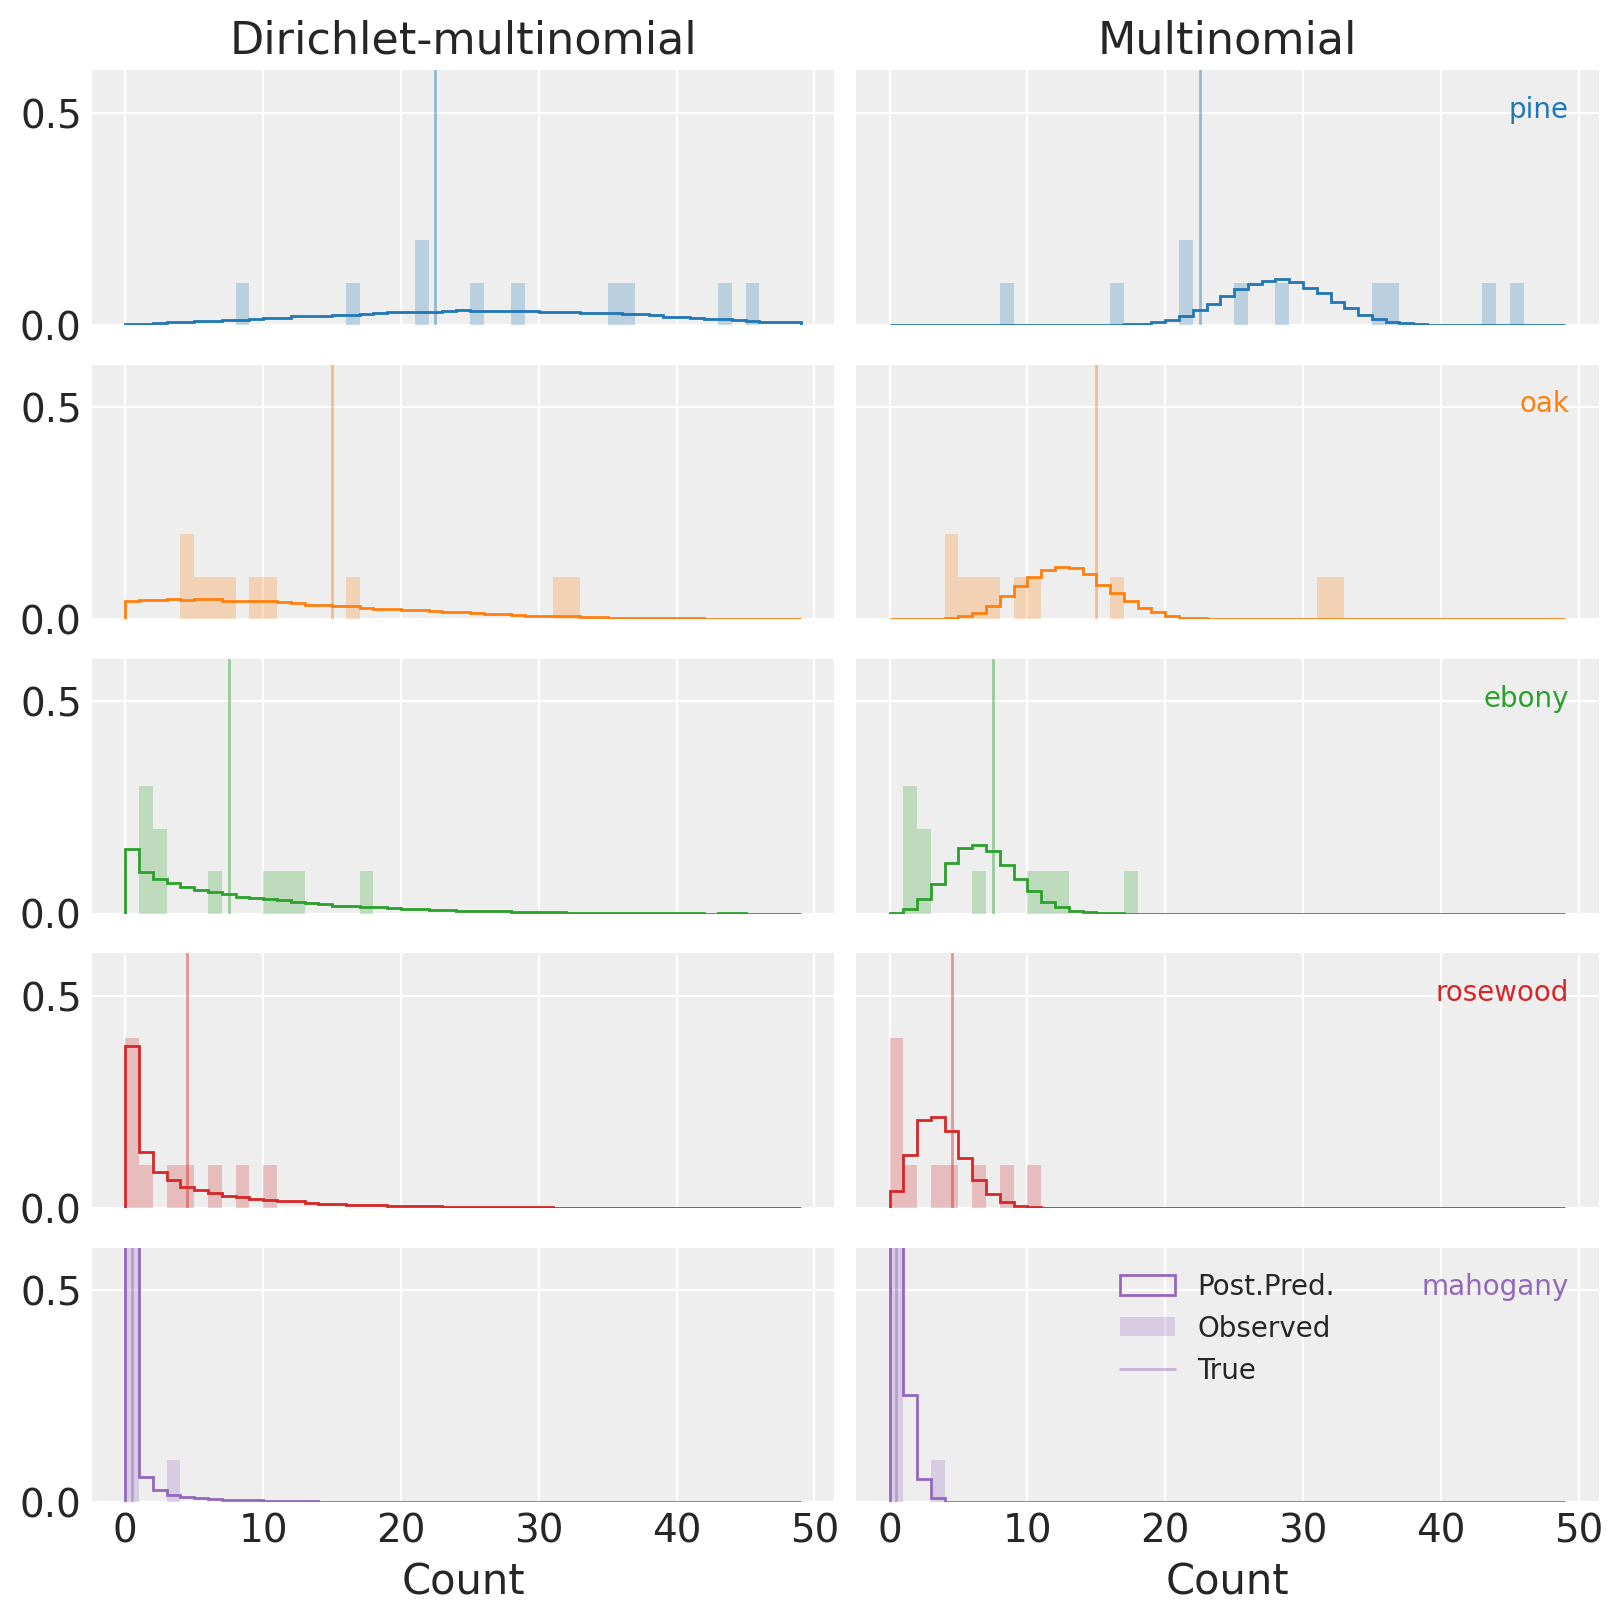

In [ ]:
cmap = plt.get_cmap("tab10")

# Crea k filas x 2 columnas, 2 graficos por especie
fig, axs = plt.subplots(k, 2, sharex=True, sharey=True, figsize=(8, 8))
for j, row in enumerate(axs):
    c = cmap(j)

    #Compara ambos modelos lado a lado
    for _trace, ax in zip([trace_dm_marginalized, trace_multinomial], row):
      #Dibuja línea gruesa: conteos simulados
        ax.hist(
            _trace.posterior_predictive.counts.sel(tree=trees[j]).values.flatten(),
            bins=np.arange(total_count),
            histtype="step",
            color=c,
            density=True,
            label="Post.Pred.",
        )

        #Dibuja área sombreada: conteos reales
        ax.hist(
            (_trace.observed_data.counts.sel(tree=trees[j]).values.flatten()),
            bins=np.arange(total_count),
            color=c,
            density=True,
            alpha=0.25,
            label="Observed",
        )

        #Dibuja línea vertical: conteo esperado real
        ax.axvline(
            true_frac[j] * total_count,
            color=c,
            lw=1.0,
            alpha=0.45,
            label="True",
        )
    row[1].annotate(
        f"{trees[j]}",
        xy=(0.96, 0.9),
        xycoords="axes fraction",
        ha="right",
        va="top",
        color=c,
    )

axs[-1, -1].legend(loc="upper center", fontsize=10)
axs[0, 1].set_title("Multinomial")
axs[0, 0].set_title("Dirichlet-multinomial")
axs[-1, 0].set_xlabel("Count")
axs[-1, 1].set_xlabel("Count")
axs[-1, 0].set_yticks([0, 0.5, 1.0])
axs[-1, 0].set_ylim(0, 0.6)
ax.set_ylim(0, 0.6);

En comparación con el multinomial (gráficos a la derecha), los PPC para el DM (izquierda) muestran que los datos observados son una realización totalmente razonable de nuestro modelo.



---

## **Comparacion de modelos**

Hasta ahora vimos visualmente y conceptualmente que el Dirichlet–Multinomial (DM) modela mejor los datos que el Multinomial simple.

Pero ahora queremos medirlo cuantitativamente

Para eso usamos una técnica llamada validación cruzada dejando una observación fuera, que evalúa qué tan bien predice el modelo datos nuevos que no fueron usados para entrenarlo.


In [ ]:
with model_multinomial:
    pm.compute_log_likelihood(trace_multinomial)

with model_dm_marginalized:
    pm.compute_log_likelihood(trace_dm_marginalized)

az.compare(
    {"multinomial": trace_multinomial, "dirichlet_multinomial": trace_dm_marginalized}, ic="loo"
)

Output()

Output()

/usr/local/lib/python3.12/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
dirichlet_multinomial,0,-96.830802,4.214552,0.000000,1.0,6.900088,0.00000,False,log
multinomial,1,-174.346338,23.668293,77.515537,0.0,24.795838,23.90468,True,log


El resultado muestra que el Dirichlet–Multinomial marginado obtiene:

* Un elpd_loo mucho mayor (mejor capacidad predictiva)
* Un peso estadístico ≈ 1.0 (100%), lo que significa que el LOO prefiere casi con certeza este modelo.

El modelo Dirichlet–Multinomial es claramente superior, tanto en predicción fuera de muestra, como en robustez estadística.



---

## **Conlusióm**

El Dirichlet–Multinomial (DM) no soluciona todos los problemas posibles, pero en la mayoría de los casos reales donde hay sobredispersión (más variabilidad de la esperada por el multinomial), ofrece una mejora clara.

Lo hace con solo un parámetro adicional (conc), lo que lo convierte en una extensión simple pero poderosa del modelo multinomial.

El DM es excelente cuando hay sobredispersión,
pero no cuando hay correlaciones estructurales entre categorías.